In [14]:
import pandas as pd
from Bio import Entrez
from time import sleep
from tqdm import tqdm
import seaborn as sns
import xml.etree.ElementTree as ET
import os

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [2]:
Entrez.email = "nd23942@bristol.ac.uk"
input_csv = "abstracts_data.csv"
output_csv = "abstracts_summary.csv"
BATCH_SIZE = 200
SLEEP_TIME = 0.34

In [4]:
df = pd.read_csv(input_csv)
pmid_list = df['PMID'].astype(str).dropna().unique().tolist()

In [5]:
def parse_pub_year(article):
    pub_date = article.find('.//PubDate')
    if pub_date is not None:
        year_elem = pub_date.find('Year')
        if year_elem is not None:
            return year_elem.text
    # fallback
    date_created = article.find('.//DateCreated')
    if date_created is not None:
        year_elem = date_created.find('Year')
        if year_elem is not None:
            return year_elem.text
    return ''

In [6]:
def parse_article(article):
    pmid = article.findtext('.//PMID')
    journal = article.findtext('.//Journal/Title') or ''

    # year
    pub_year = parse_pub_year(article)

    # type
    pub_types = article.findall('.//PublicationType')
    pub_type_list = [pt.text for pt in pub_types if pt is not None]
    pub_type_str = '; '.join(pub_type_list)

    # MeSH terms
    mesh_terms = []
    for mesh in article.findall('.//MeshHeading'):
        descriptor = mesh.find('DescriptorName')
        if descriptor is not None:
            mesh_terms.append(descriptor.text)
    mesh_str = '; '.join(mesh_terms)

    return {
        'pmid': pmid,
        'pub_year': pub_year,
        'journal': journal,
        'publication_types': pub_type_str,
        'mesh_terms': mesh_str
    }

In [7]:
results = []
for i in tqdm(range(0, len(pmid_list), BATCH_SIZE), desc="Fetching PubMed metadata"):
    batch_pmids = pmid_list[i:i + BATCH_SIZE]
    try:
        handle = Entrez.efetch(db="pubmed", id=",".join(batch_pmids), retmode="xml")
        root = ET.parse(handle).getroot()
        for article in root.findall("PubmedArticle"):
            try:
                parsed = parse_article(article)
                results.append(parsed)
            except Exception as e:
                print(f"Parse error: {e}")
        sleep(SLEEP_TIME)
    except Exception as e:
        print(f"Fetch error at batch {i}: {e}")
        sleep(5)

# save
pd.DataFrame(results).to_csv(output_csv, index=False)
print(f"saved in {output_csv}")

Fetching PubMed metadata: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:08<00:00,  1.96s/it]

saved in abstracts_summary.csv


In [12]:
df = pd.read_csv("abstracts_summary.csv")

sns.set(style="whitegrid", font_scale=1.2)

df['pub_year'] = pd.to_numeric(df['pub_year'], errors='coerce')
df = df[df['pub_year'].notna()]
df['pub_year'] = df['pub_year'].astype(int)

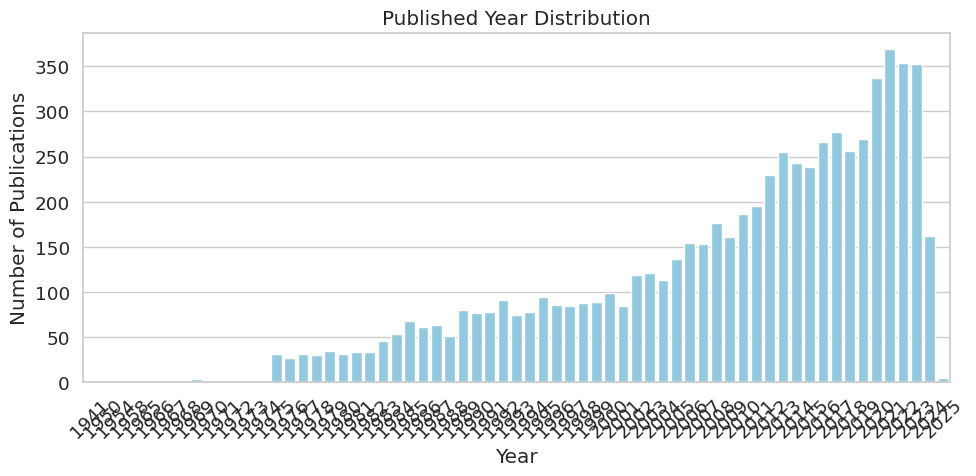

In [18]:
# Year Distribution
year_counts = df['pub_year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=year_counts.index, y=year_counts.values, color='skyblue')
plt.title("Published Year Distribution")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"year_distribution.png")

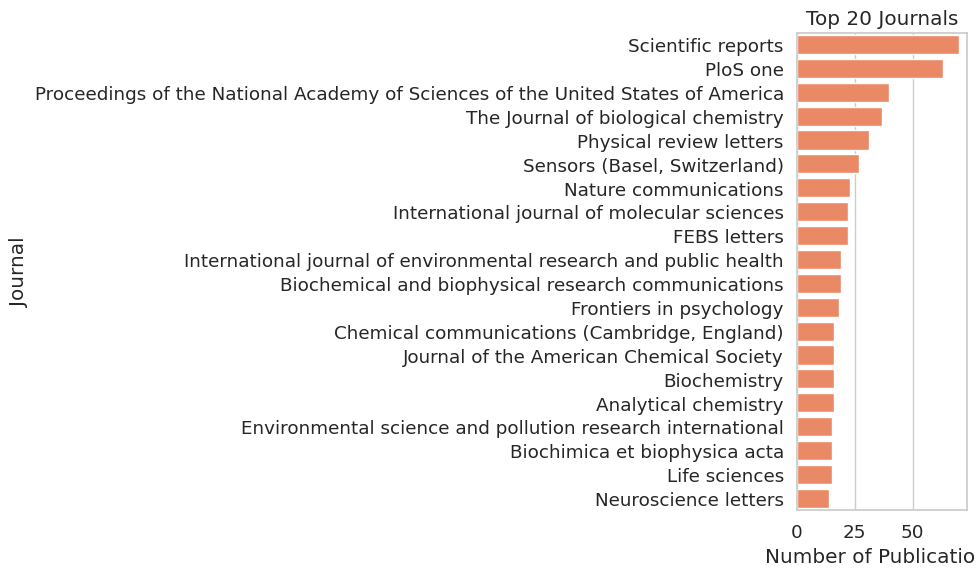

In [20]:
# Top N Journals
TOP_N = 20

journal_counts = df['journal'].value_counts().nlargest(TOP_N)
plt.figure(figsize=(10, 6))
sns.barplot(y=journal_counts.index, x=journal_counts.values, color='coral')
plt.title(f"Top {TOP_N} Journals")
plt.xlabel("Number of Publications")
plt.ylabel("Journal")
plt.tight_layout()
plt.savefig(f"top_journals.png")

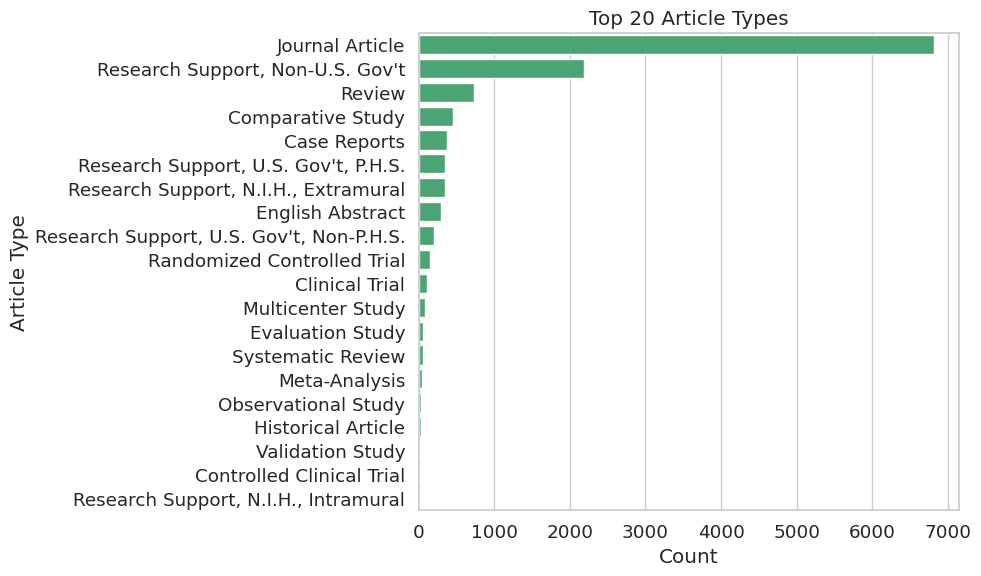

In [21]:
# Top N Publication Types
pubtype_list = df['publication_types'].dropna().str.split('; ')
flat_pubtypes = [pt for sublist in pubtype_list for pt in sublist]
pubtype_counts = Counter(flat_pubtypes)
pubtype_df = pd.DataFrame(pubtype_counts.most_common(TOP_N), columns=['PublicationType', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(y='PublicationType', x='Count', data=pubtype_df, color='mediumseagreen')
plt.title(f"Top {TOP_N} Article Types")
plt.xlabel("Count")
plt.ylabel("Article Type")
plt.tight_layout()
plt.savefig(f"publication_types.png")

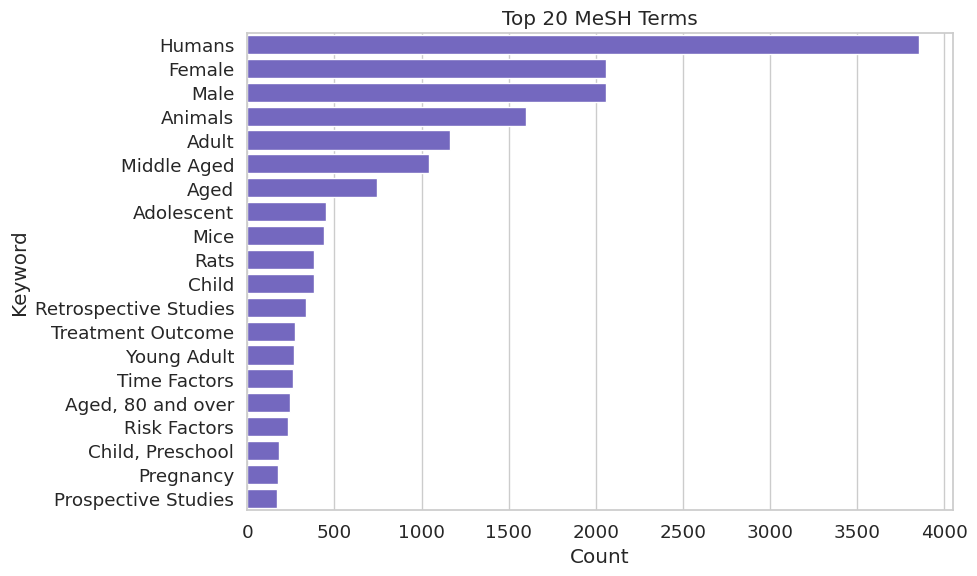

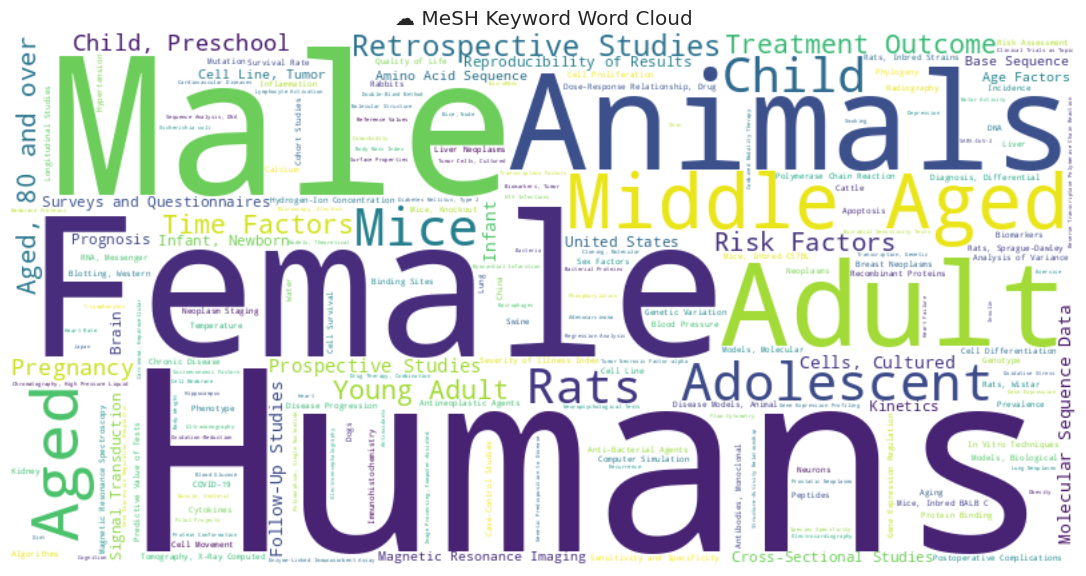

In [23]:
# MeSH Top N + wordCloud
mesh_terms = df['mesh_terms'].dropna().str.split('; ')
mesh_flat = [m.strip() for sublist in mesh_terms for m in sublist]
mesh_counts = Counter(mesh_flat)
top_mesh = pd.DataFrame(mesh_counts.most_common(TOP_N), columns=['Keyword', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Keyword', data=top_mesh, color='slateblue')
plt.title(f"Top {TOP_N} MeSH Terms")
plt.tight_layout()
plt.savefig(f"mesh_top_keywords.png")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mesh_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("☁️ MeSH Keyword Word Cloud")
plt.tight_layout()
plt.savefig(f"mesh_wordcloud.png")

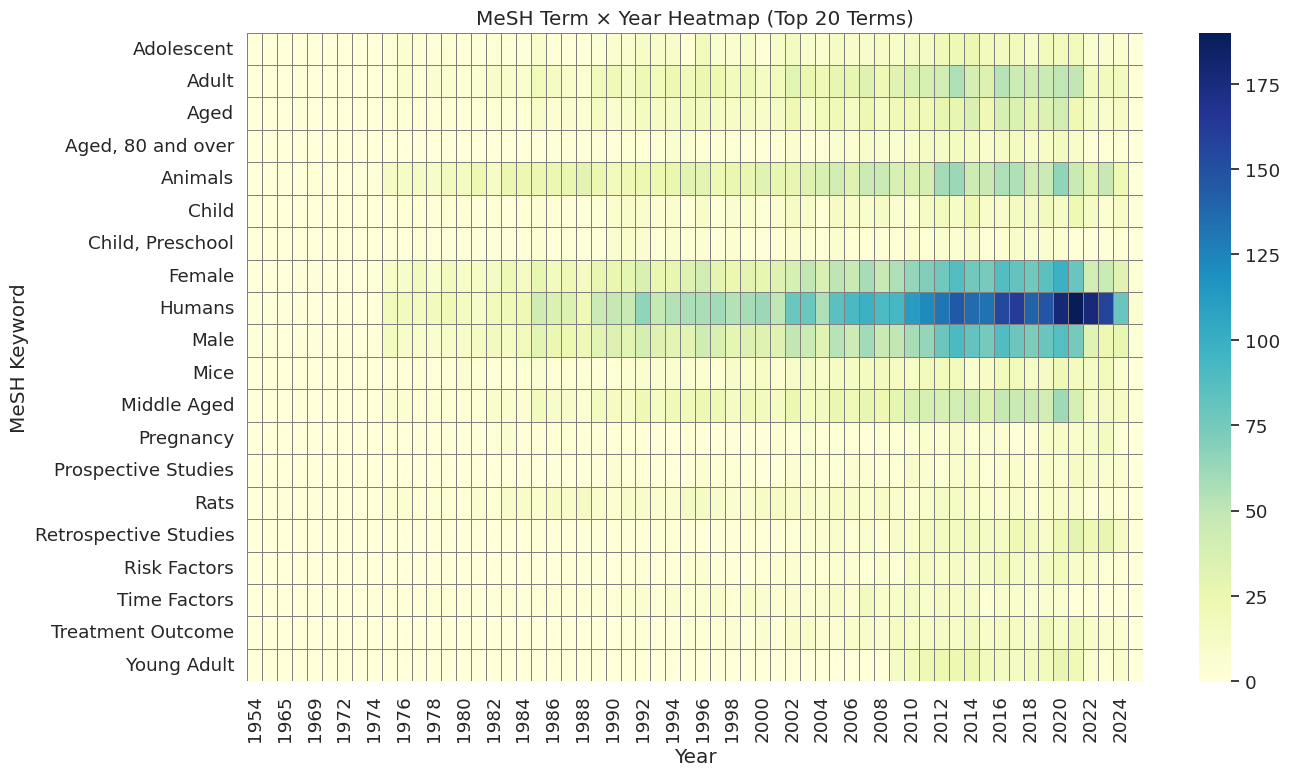

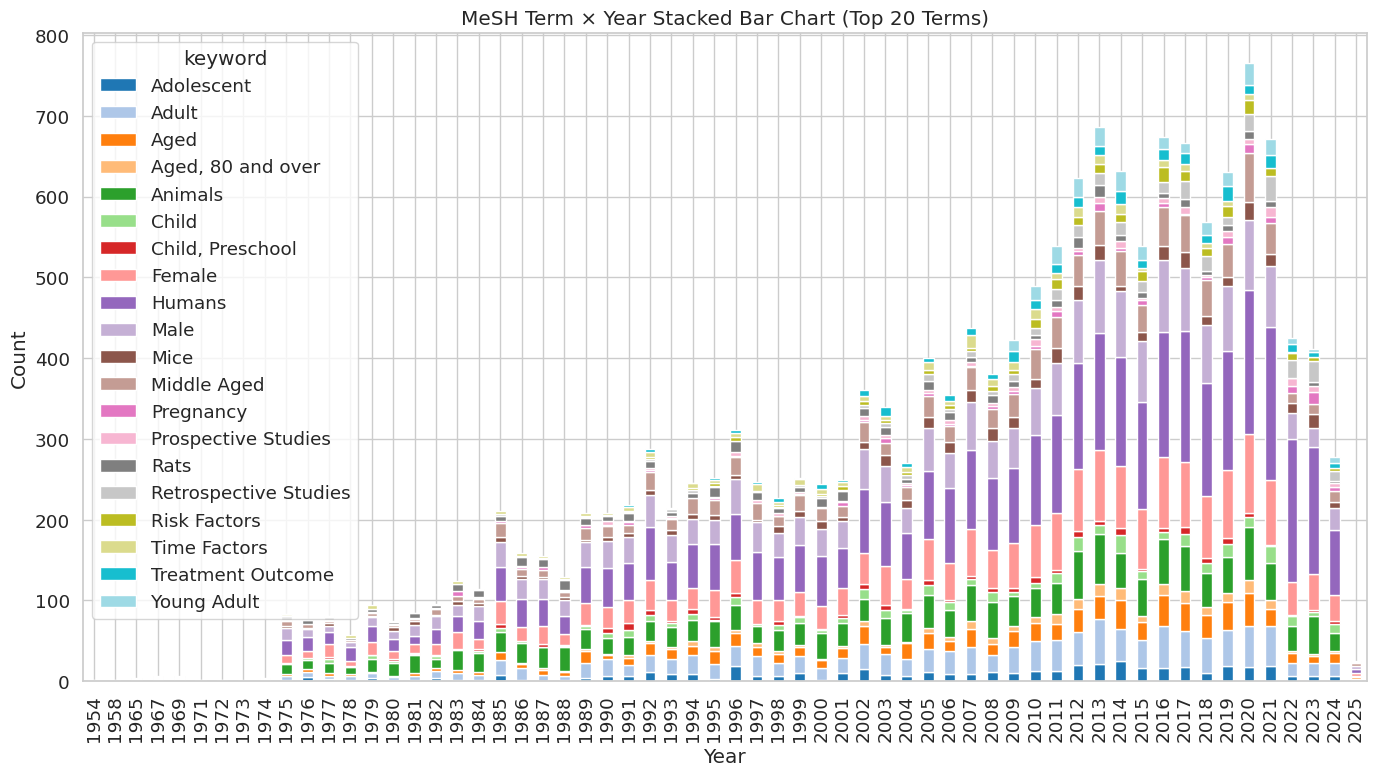

In [24]:
# MeSH Keywords × Year Heatmap + Stacked Bar Chart
top_keywords = [kw for kw, _ in mesh_counts.most_common(TOP_N)]

# Construction of Keyword × Year Count Matrix
rows = []
for _, row in df[['pub_year', 'mesh_terms']].dropna().iterrows():
    year = row['pub_year']
    keywords = [kw.strip() for kw in row['mesh_terms'].split(';') if kw.strip() in top_keywords]
    for kw in keywords:
        rows.append((year, kw))
heat_df = pd.DataFrame(rows, columns=['year', 'keyword'])
pivot = heat_df.groupby(['year', 'keyword']).size().reset_index(name='count')
heatmap_df = pivot.pivot(index='keyword', columns='year', values='count').fillna(0)

# HeatMap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=.5, linecolor='gray')
plt.title("MeSH Term × Year Heatmap (Top 20 Terms)")
plt.xlabel("Year")
plt.ylabel("MeSH Keyword")
plt.tight_layout()
plt.savefig(f"mesh_keyword_year_heatmap.png")

# Stacked Bar Chart
pivot_bar = heatmap_df.T.sort_index()
pivot_bar.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title("MeSH Term × Year Stacked Bar Chart (Top 20 Terms)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"mesh_keyword_year_stacked_bar.png")